## Collect data from Pylon CCD

First start the image server by running "sudo python Server.py" in the /home/photon/code/Camserver folder

In [1]:
%matplotlib inline 

In [2]:
import numpy as np
import os
import zmq
from scipy import stats
from collections import Counter 
from numpy.fft import fft,fftshift
from numpy import real, imag, abs, frombuffer, angle
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append('/home/photon/code/PylonCCD')
import serial
import time
import datetime
import Qfunction as Qfunc

In [3]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

In [4]:
""" Set up lists to hold the analysis output, only call this cell to clear the data before a new round of collection """
output = []

### Setup communication with the Camserver (being refactored into DLutil/DLcamclient)

In [5]:
def recv_array(socket, flags=0, copy=False, track=False):
    """recv a numpy array"""
    md = socket.recv_json(flags=flags)
    msg = socket.recv(flags=flags, copy=copy, track=track)
    buf = memoryview(msg)
    A = frombuffer(buf, dtype=md['dtype'])
    return A.reshape(md['shape'])

In [6]:
REQUEST_TIMEOUT = 25000
SERVER_ENDPOINT = "tcp://localhost:5555"

context = zmq.Context()

#  Socket to talk to server
print("Connecting to array server...")
client = context.socket(zmq.REQ)
client.connect(SERVER_ENDPOINT)

poll = zmq.Poller()
poll.register(client, zmq.POLLIN)

Connecting to array server...


In [7]:
def request_images(client,N=1):
    shots_requested = N
    request = str(shots_requested)  # ask for one shot of data
    #print "I: Sending (%s)" % request
    
    client.send(str.encode(request))

In [8]:
def open_images():
    socks = dict(poll.poll(REQUEST_TIMEOUT))
    if socks.get(client) == zmq.POLLIN:
        data_array = recv_array(client)
        #reply = client.recv()
    
        if len(data_array) > 1:  # TODO test for the right size array
            #print "I: Server replied OK: " + str(data_array.shape)
            return data_array
    
        else:
            # print "E: Malformed reply from server: %s" % reply
            print("E: no reply from server")
            return -1

In [9]:
#TODO: refactor these into a single utility module
def saveQfig(root_path = "/home/photon/Dropbox/Data/"):
    """
    Save Qfig data as .png of qfunc and .npy of array of complex max values of fft's
    Creates a folder with today's date: 01-13-2014
    If folder for today doesn't exist, create it; else navigate to appropriate folder
    """
    target_folder = datetime.datetime.now().strftime("%m-%d-%Y")
    if not os.path.exists(root_path + target_folder):
        os.makedirs(root_path + target_folder)
    os.chdir(root_path + target_folder)
    
    
    filename = datetime.datetime.now().strftime("%H-%M-%S")# based on time and date
    qfig.savefig(filename)
    np.save(filename, output)
    
    print(filename)

In [10]:
#TODO: refactor into utility module
def saveRaw(root_path = "/home/photon/data/"):
    """
    Save Raw zipped data as .npz of array of complex max values of fft's
    Creates a folder with today's date: 01-13-2014
    If folder for today doesn't exist, create it; else navigate to appropriate folder
    """
    target_folder = datetime.datetime.now().strftime("%m-%d-%Y")
    if not os.path.exists(root_path + target_folder):
        os.makedirs(root_path + target_folder)
    os.chdir(root_path + target_folder)
    
    
    filename = datetime.datetime.now().strftime("%H-%M-%S") + "_raw"  # based on time and date
    np.savez(filename, VacCorrected=VacCorrected, ncount=ncount)
    
    print(filename)

### Setup and test the arduino-controlled shutter

In [11]:
shutter = serial.Serial("/dev/ttyACM1")
def sigOpen():
    shutter.write(str.encode("b\n"))

In [12]:
def sigClose():
    shutter.write(str.encode("a\n"))

In [13]:
sigClose()

In [14]:
sigOpen()

## Use these cells to check acquisition etc, and collect BG
## Block at CCD

In [15]:
request_images(client,N=3)

In [16]:
background_shots = open_images()

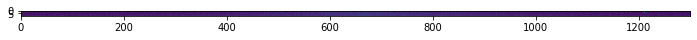

In [17]:
plt.imshow(background_shots[:,:,0])

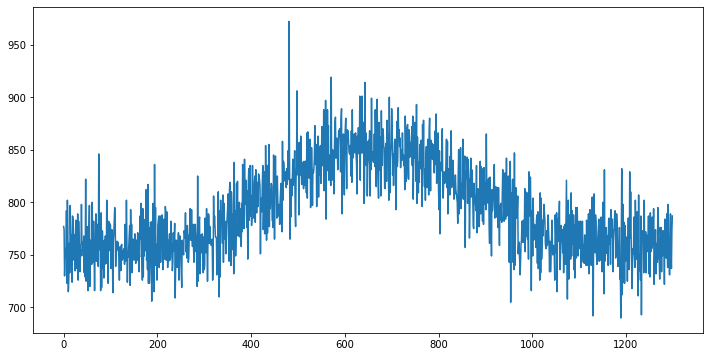

In [18]:
# take the last shot as the background
# this a workaround to account for the extra signal that comes in on the first shot
# TODO: figure this out.
background = background_shots[:,:,-1]  
background = background[:,:,np.newaxis]

plt.plot(background[5,:,0])

## Remove beam block at CCD

In [19]:
request_images(client,N=5)

In [20]:
data = open_images()

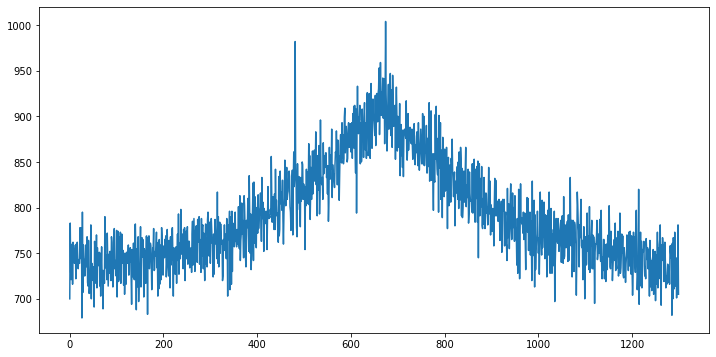

In [21]:
plt.plot(data[5,:,0])

In [22]:
corrected = data - background

In [23]:
# calculate power in Watts
corrected.sum() * 2.54704992e-19 / (6e-3 * 5) 

9.590491965440001e-14

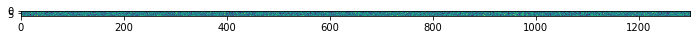

In [24]:
plt.imshow(corrected[:,:,-1])

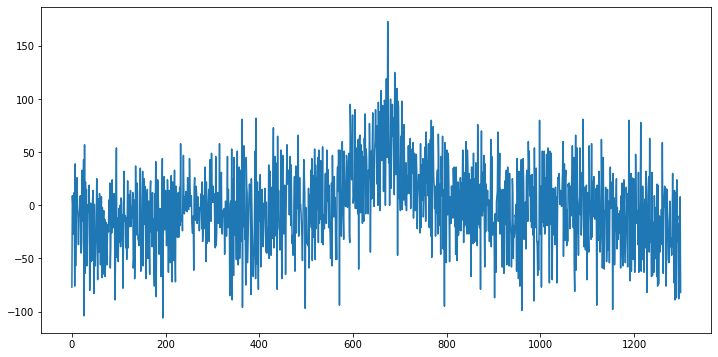

In [25]:
plt.plot(corrected[5,:,0])

Text(0, 0.5, 'Amplitude')

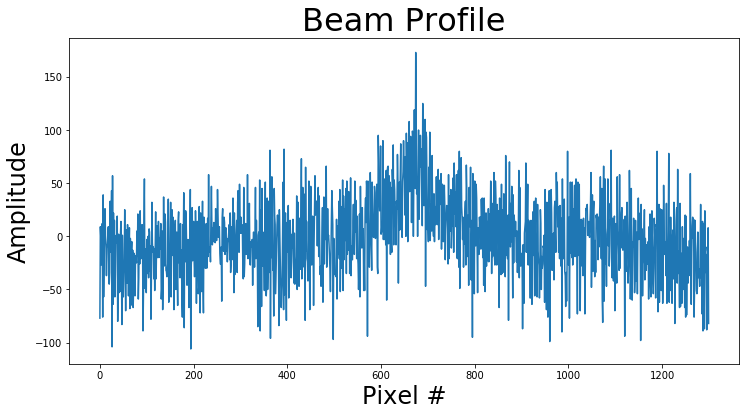

In [26]:
plt.plot(corrected[5,:,0])
#plt.plot(background[5,:,0])
plt.title("Beam Profile", fontsize=32)
plt.xlabel("Pixel #", fontsize=24)
plt.ylabel("Amplitude",fontsize=24)
#plt.xlim(400,450)

Text(0, 0.5, 'Amplitude')

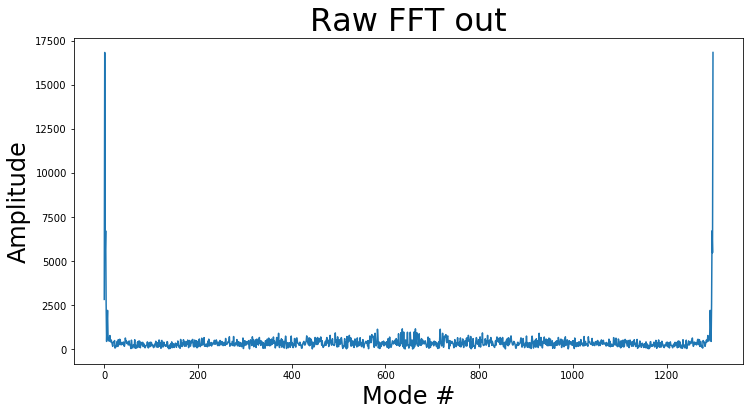

In [28]:
plt.plot((abs(fft( np.average(corrected[:,:,0],axis = 0))))[0:1340] )
plt.title("Raw FFT out", fontsize=32)
plt.xlabel("Mode #", fontsize=24)
plt.ylabel("Amplitude",fontsize=24)
#plt.ylim([0,1e6])

# This is the one-cell version:
Starts with a vacuum collection, then does a full data set.

In [61]:
#Interspersed vacuum and data runs:

frames = 3 # frames to collect (this is sent to th e ZMQ server)
rounds = 3 # rounds of data (total shots is N*M)

dataOut = np.empty([1300,frames,rounds],dtype=complex)
vacOut = np.empty([1300,frames,rounds],dtype=complex)
VacCorrected = np.empty([1300,frames,rounds],dtype=complex)
ncount = np.empty([frames,rounds])
for r in range(rounds): # take M rounds:
    print "vacuum round: %i" % (r+1)
    time.sleep(2)
    sigClose()
    time.sleep(2)
    request_images(client,frames)
    vac = open_images()
    if frames != vac.shape[2]:
        print "Warning, frame shape mismatch"
    ydim = vac.shape[0]
    xdim = vac.shape[1]
    
    for f in range (0, frames):

        
        BGcorrected_vac = vac[:,:,f] - background[:,:,0] # could probably speed this up?

        # vertical sum over all rows, then fftshift, then fft:
        vacOut[:,f,r] = fft( fftshift( BGcorrected_vac.sum(axis = 0) ) )
        
    vacFFT = np.average(vacOut[:,:,r],axis=1)
    
    print "data round: %i" % (r+1)
    time.sleep(2)
    sigOpen()
    time.sleep(2)
    
    request_images(client,frames)
    data = open_images()
    if frames != vac.shape[2]:
        print "Warning, frame shape mismatch"
    ydim = data.shape[0]
    xdim = data.shape[1]
    for f in range (0, frames):
 
        BGcorrected = data[:,:,f] - background[:,:,0] # could probably speed this up?
        
        # Track the total power (i.e. sum all photons detected)
        ncount[f,r] = BGcorrected.sum()
    
        # vertical sum over middle 10 rows, then fftshift, then fft:
        dataOut[:,f,r] = fft( fftshift( BGcorrected.sum(axis = 0) ) )
    
    VacCorrected[:,:,r] = dataOut[:,:,r] - vacFFT.reshape(1300,1)

print "Finished data"
saveRaw()


vacuum round: 1
data round: 1
vacuum round: 2
data round: 2
vacuum round: 3
data round: 3
Finished data
09-33-45_raw


## Log data filenames at this point!

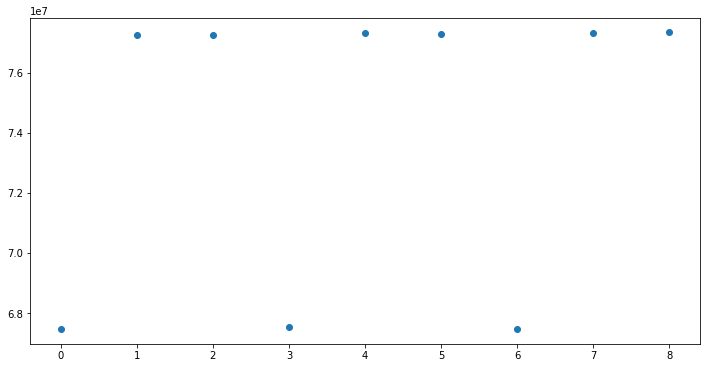

In [62]:
# This should be constant, no big drops or peaks. It is basically a measure of the LO power vs time.
plt.plot(ncount.flatten('F'),"o")
#plt.ylim([4e7,7e7])

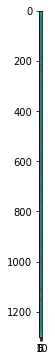

In [63]:
# Look at structure in the VacCorrected array vs. time
# Should be quiet except for where the signal is. Expect some peaks at the top and bottom edges (i.e. near DC)
plt.imshow(np.log10(abs( VacCorrected.reshape(1300,rounds*frames) )))

(0, 100000.0)

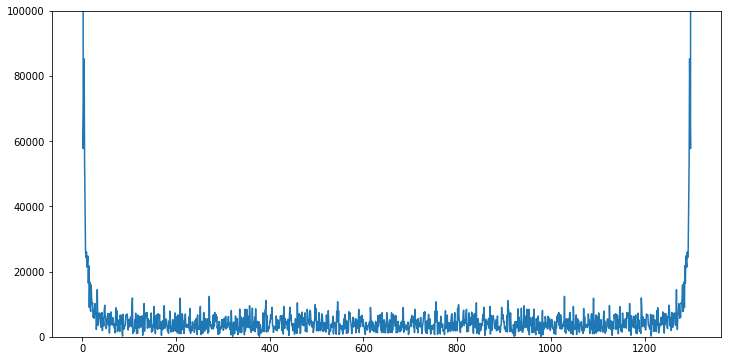

In [64]:
# full FFT output averaged for the data set
# needs to be quite flat above p = 200
# plt.plot( np.log10(abs((np.average(VacCorrected,axis=(1,2)))) ))
plt.plot( (abs((np.average(VacCorrected,axis=(1,2)))) ))
plt.ylim([0,1e5])

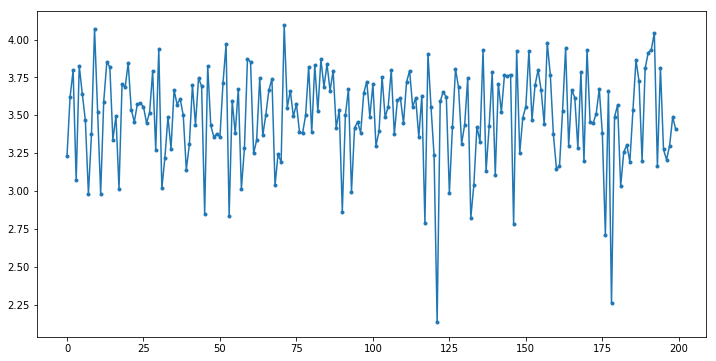

In [65]:
# look near the mode of interest (only useful for the strong-signal data)
plt.plot( np.log10(abs((np.average(VacCorrected,axis=(1,2)))) )[200:400],".-")

In [43]:
selectedMode = 425
output = (np.sqrt(2.0/ncount) * VacCorrected[selectedMode,:,:]).flatten('F')  
# Choose the mode to analyze, with n_t scaling

# output = VacCorrected[selectedMode,:,:].flatten()  # Choose the mode to analyze

Average amplitude: 48.631373


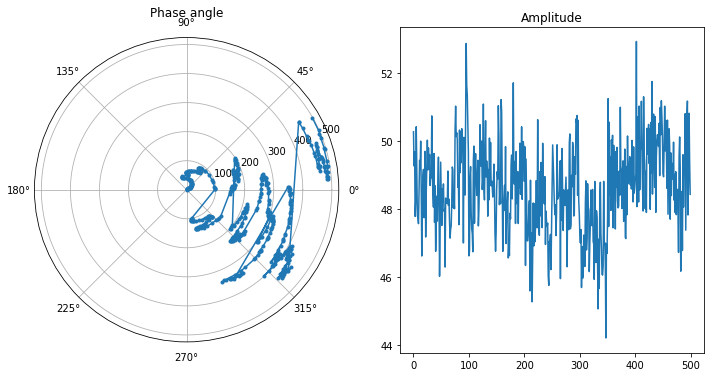

In [156]:
# Look at the average amplitude and a plot of phase angle and amplitude vs. shot number:
plt.subplot(121, polar=True)
plt.plot(angle(output),np.arange(len(output)),".-")
plt.title("Phase angle")
plt.subplot(122)
#plt.ylim(0,20)
plt.plot(abs(output))
plt.title("Amplitude")
print "Average amplitude: %f" % np.average(abs(output))

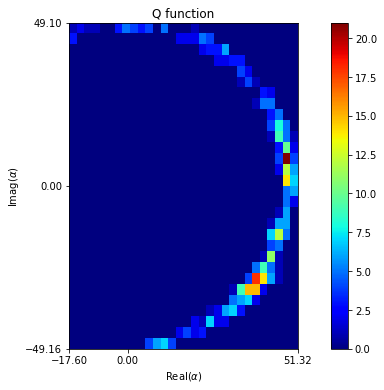

In [157]:
qfig = Qfunc.qfuncimage(output,30,0)

In [157]:
saveQfig()

11-37-14


# Use the following for shot noise measurement

Note, this is wrong, we need to create this plot for the mode we analyze. In other words, go through more of the analysis and plot var(Kp) vs mean(Kp) for a specific mode. Can modify this code!

In [124]:
sys.path.append('/home/photon/code/Instruments')
import instrument
import time

In [127]:
rigolDG = instrument.RigolDG("/dev/usbtmc0")

Rigol Technologies,DG4102,DG4B151400125,00.01.04



In [337]:
datapoints = 12
means = numpy.zeros((10,600,datapoints))
variances = numpy.zeros((10,600,datapoints))
powers = numpy.linspace(1,5,datapoints)
#print powers
shot = 0
for lo_power in powers:
    command = ":VOLT:HIGH %s" % lo_power
    #print command
    rigolDG.write(command)
    time.sleep(2)
    request_images(client,N=100)
    data = open_images()
    #pylab.imshow(data[:,:,50])
    #pylab.show()
    print "Collected shot number %g" % (shot)
    #summed = data.sum(axis=0)
    means[:,:,shot] = data.mean(axis=2)
    variances[:,:,shot] = data.var(axis=2)
    #pylab.imshow(variances[:,:,shot])
    #pylab.show()
    shot+=1
    
print "Finished"

I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 0
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 1
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 2
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 3
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 4
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 5
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 6
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 7
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 8
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 9
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 10
I: Sending (100)
I: Server replied OK: (10, 600, 100)
Collected shot number 11
Finished


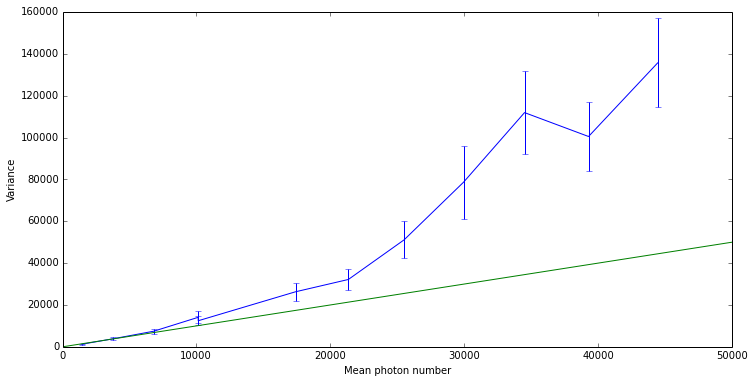

In [338]:
submeans = means[:,250:350,:]
subvars = variances[:,250:350,:]
x = submeans.mean(axis=(0,1))
y = subvars.mean(axis=(0,1))
yerr = subvars.std(axis=(0,1))
pylab.errorbar(x,y,yerr=yerr)
pylab.plot(numpy.arange(50000),numpy.arange(50000))
pylab.xlabel("Mean photon number")
pylab.ylabel("Variance")

In [214]:
from scipy import stats

In [339]:
slope, intercept, r_value, p_value, std_err = stats.linregress(submeans.flatten('F'),subvars.flatten('F'))
print slope
print std_err

3.17620871733
0.00943766085919


# Use the following to verify SNR

In [90]:
request_images(client,N=5)

I: Sending (5)


In [91]:
blocked = open_images()

I: Server replied OK: (10, 600, 5)


In [239]:
request_images(client,N=4)

I: Sending (4)


In [240]:
unblocked = open_images()

I: Server replied OK: (10, 600, 4)


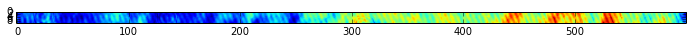

In [241]:
pylab.imshow(unblocked[:,:,:].mean(axis=2))

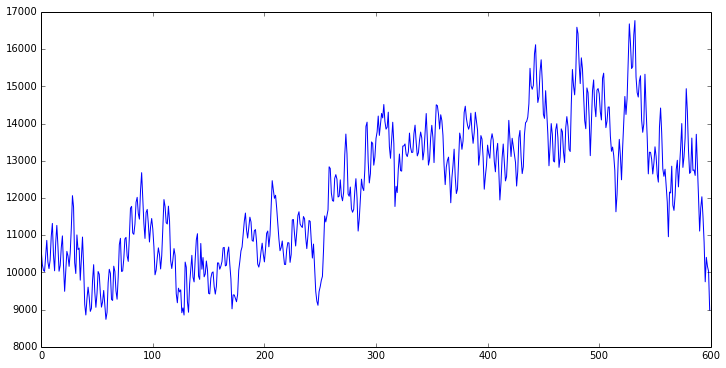

In [245]:
pylab.plot(unblocked[5,:,:].mean(axis=1))

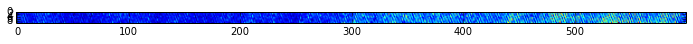

In [98]:
pylab.imshow(unblocked[:,:,:].var(axis=2))

In [104]:
snr = (unblocked-background).var(axis=2) / (blocked-background).var(axis=2)

In [105]:
snr.mean()

992.96047592928085

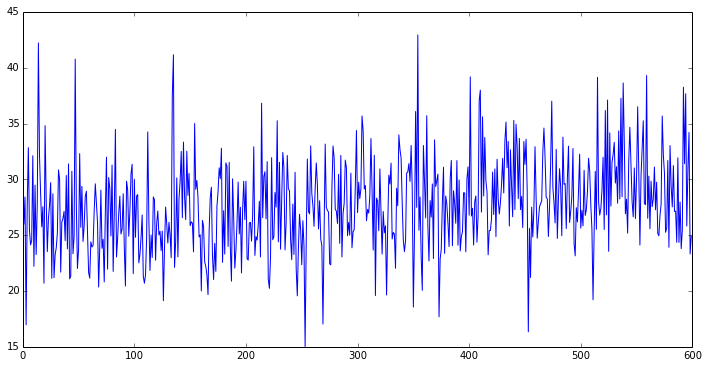

In [106]:
pylab.plot(10*np.log10(snr[5,:]))

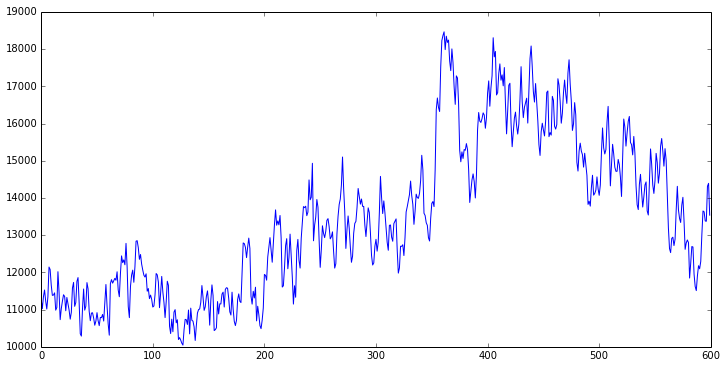

In [35]:
pylab.plot((unblocked-background)[5,:,0])